# Analysis of Highlands at Mayfield and Parkside at Mayfield work orders

In [5]:
# Dependencies
import pandas as pd
import pyodbc

# SQL Alchemy imports
from sqlalchemy import create_engine

In [26]:
gis_conn = (
    'mssql+pyodbc:///?odbc_connect='
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=srvvmsdeprod;'
    'DATABASE=MAP;'
    'Trusted_Connection=yes;'
)

In [80]:
eam_conn = (
    'mssql+pyodbc:///?odbc_connect='
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=srvvmeamproddb;'
    'DATABASE=EAMDB;'
    'Trusted_Connection=yes;'
)

In [27]:
# Create the gis engine
gis_engine = create_engine(gis_conn, echo=True)

In [76]:
# GIS queries

gravity_mains_query = '''
        SELECT GISOBJID,
               ADDRESS,
               OWNER 
        FROM gtown.GRAVITYMAIN
        WHERE ADDRESS IN (SELECT Label_Name from gtown.P3_PREMISESPT WHERE SUB_NAME LIKE ('%MAYFIELD%'));
        '''

force_mains_query = '''
        SELECT GISOBJID,
               ADDRESS,
               OWNER 
        FROM gtown.PRESSURIZEDMAIN
        WHERE ADDRESS IN (SELECT Label_Name from gtown.P3_PREMISESPT WHERE SUB_NAME LIKE ('%MAYFIELD%'));
        '''

premises_query = '''
        SELECT COGEAMID,
               PREMISESID,
               Label_Name,
               SUB_NAME
        FROM gtown.P3_PREMISESPT
        WHERE SUB_NAME LIKE ('%MAYFIELD%')
'''

manhole_query = '''
        SELECT GISOBJID,
               ADDRESS,
               OWNER
        FROM gtown.WASTEWATERMANHOLE
        WHERE ADDRESS IN (SELECT Label_Name from gtown.P3_PREMISESPT WHERE SUB_NAME LIKE ('%MAYFIELD%'));
'''

ls_query = '''
        SELECT OBJECTID,
               NAME,
               ADDRESS,
               OWNER
        FROM gtown.WastewaterNetworkStructure
        WHERE EAM_CAT = 'Lift Station'
        AND OWNER = 'PARKSIDE';
'''

In [77]:
grav_mains = pd.read_sql_query(gravity_mains_query, gis_engine)
force_mains = pd.read_sql_query(force_mains_query, gis_engine)
premises = pd.read_sql_query(premises_query, gis_engine)
manholes = pd.read_sql_query(manhole_query, gis_engine)
lift_stations = pd.read_sql_query(ls_query, gis_engine)

2023-09-18 14:40:34,364 INFO sqlalchemy.engine.Engine 
        SELECT GISOBJID,
               ADDRESS,
               OWNER 
        FROM gtown.GRAVITYMAIN
        WHERE ADDRESS IN (SELECT Label_Name from gtown.P3_PREMISESPT WHERE SUB_NAME LIKE ('%MAYFIELD%'));
        
2023-09-18 14:40:34,365 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-09-18 14:40:34,463 INFO sqlalchemy.engine.Engine 
        SELECT GISOBJID,
               ADDRESS,
               OWNER 
        FROM gtown.PRESSURIZEDMAIN
        WHERE ADDRESS IN (SELECT Label_Name from gtown.P3_PREMISESPT WHERE SUB_NAME LIKE ('%MAYFIELD%'));
        
2023-09-18 14:40:34,463 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-09-18 14:40:34,562 INFO sqlalchemy.engine.Engine 
        SELECT COGEAMID,
               PREMISESID,
               Label_Name,
               SUB_NAME
        FROM gtown.P3_PREMISESPT
        WHERE SUB_NAME LIKE ('%MAYFIELD%')

2023-09-18 14:40:34,562 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-09-18 14:40

In [66]:
grav_mains.head()

,GISOBJID,ADDRESS,OWNER
0,100069244,264 CADDO LAKE DR,PARKSIDE
1,100069253,113 BATTLESHIP DR,PARKSIDE
2,100069256,112 MISSION TEJAS ST,PARKSIDE
3,100068446,216 WESTFIELD DR,PARKSIDE
4,100068447,3736,PARKSIDE


In [67]:
force_mains.head()

,GISOBJID,ADDRESS,OWNER
0,100015392,336 LAKE LIVINGSTON DR,PARKSIDE


In [68]:
premises.head()

,COGEAMID,PREMISESID,Label_Name,SUB_NAME
0,9C17774E,PRM0036729,208 BATTLESHIP DR,PARKSIDE AT MAYFIELD RANCH
1,25C4F4FA,PRM0037946,209 SEMINOLE CANYON DR,PARKSIDE AT MAYFIELD RANCH
2,59A1AE5B,PRM0038929,409 PURTIS CREEK LN,PARKSIDE AT MAYFIELD RANCH
3,E8CBB05D,PRM0032829,128 COPPER LAKE LN,PARKSIDE AT MAYFIELD RANCH
4,7D003D2D,PRM0032131,272 CADDO LAKE DR,PARKSIDE AT MAYFIELD RANCH


In [73]:
manholes.head()

,GISOBJID,ADDRESS,OWNER
0,100060209,348 LAKE LIVINGSTON DR,PARKSIDE
1,100060214,224 CHOKE CANYON LN,PARKSIDE
2,100060245,3821,PARKSIDE
3,100061824,101 GUADALUPE RIVER CV,PARKSIDE
4,100061826,101 GUADALUPE RIVER CV,PARKSIDE


In [70]:
lift_stations.head()

,OBJECTID,NAME,ADDRESS,OWNER
0,71,MAYFIELD RANCH LS,1577 CR 176,PARKSIDE
1,76,HIGHLANDS LS,5421,PARKSIDE


Collect the work orders from EAM that have at least one of the object IDs from above.

In [82]:
# Create the eam engine
eam_engine = create_engine(eam_conn, echo=True)

In [329]:
query = '''
    SELECT wo.EVT_CODE,
           EVT_DATE as date,
           EVT_LOCATION as location,
           obj.OBJ_CODE as obj_code,
           OBJ.OBJ_GISOBJID as gis_id,
           obj.OBJ_CLASS as obj_class,
           hrs.BOO_OCTYPE as labor_type, 
           SUM(hrs.BOO_HOURS) as booked_labor
    FROM R5EVENTS AS wo
    JOIN R5BOOKEDHOURS AS hrs
        ON wo.EVT_CODE = hrs.BOO_EVENT
    JOIN R5OBJECTS as obj
        ON wo.EVT_OBJECT = obj.OBJ_CODE
    WHERE EVT_TYPE = 'JOB'
    AND EVT_STATUS NOT IN ('CANC', 'REJ')
    --AND EVT_LOCATION IN ('HML', 'MFL')
    --OR obj.OBJ_GISOBJID IN (%mh, %grav_mains, %force_mains) -- Gravity Mains, Force Mains, Manholes
    --OR EVT_OBJECT IN (%premises) -- Premises
    --OR EVT_OBJECT IN (%addresses) -- Addresses
    
    GROUP BY wo.EVT_DATE, EVT_CODE, EVT_LOCATION, obj.OBJ_CODE, obj.OBJ_GISOBJID, obj.OBJ_CLASS, hrs.BOO_OCTYPE
    ORDER BY wo.EVT_DATE
'''

work_orders = pd.read_sql_query(query, eam_engine)

# work_orders = pd.read_sql_query(
#     query, 
#     eam_engine, 
#      params={
#         'mh': manholes.GISOBJID,
#         'grav_mains': grav_mains.GISOBJID,
#         'force_mains': force_mains.GISOBJID,
#         'premises': premises.PREMISESID,
#         'addresses': premises.COGEAMID
#     }
# )

2023-09-22 12:32:29,919 INFO sqlalchemy.engine.Engine 
    SELECT wo.EVT_CODE,
           EVT_DATE as date,
           EVT_LOCATION as location,
           obj.OBJ_CODE as obj_code,
           OBJ.OBJ_GISOBJID as gis_id,
           obj.OBJ_CLASS as obj_class,
           hrs.BOO_OCTYPE as labor_type, 
           SUM(hrs.BOO_HOURS) as booked_labor
    FROM R5EVENTS AS wo
    JOIN R5BOOKEDHOURS AS hrs
        ON wo.EVT_CODE = hrs.BOO_EVENT
    JOIN R5OBJECTS as obj
        ON wo.EVT_OBJECT = obj.OBJ_CODE
    WHERE EVT_TYPE = 'JOB'
    AND EVT_STATUS NOT IN ('CANC', 'REJ')
    --AND EVT_LOCATION IN ('HML', 'MFL')
    --OR obj.OBJ_GISOBJID IN (%mh, %grav_mains, %force_mains) -- Gravity Mains, Force Mains, Manholes
    --OR EVT_OBJECT IN (%premises) -- Premises
    --OR EVT_OBJECT IN (%addresses) -- Addresses
    
    GROUP BY wo.EVT_DATE, EVT_CODE, EVT_LOCATION, obj.OBJ_CODE, obj.OBJ_GISOBJID, obj.OBJ_CLASS, hrs.BOO_OCTYPE
    ORDER BY wo.EVT_DATE

2023-09-22 12:32:29,920 INFO sqlalchemy.en

In [330]:
work_orders.head()

,EVT_CODE,date,location,obj_code,gis_id,obj_class,labor_type,booked_labor
0,238095,2012-07-26 17:06:00,None,5FCFD134,100082930.0,ADDRESS,N,22.0
1,164535,2014-09-22 00:00:00,RHP,W-DS-RHP,NaN,STATION,N,2.0
2,161227,2014-10-09 10:15:00,None,COG,NaN,None,N,2.0
3,162521,2014-10-09 14:49:00,None,COG,NaN,None,N,4.0
4,162567,2014-10-09 16:47:00,None,COG,NaN,None,N,14.0


In [649]:
work_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182187 entries, 0 to 182186
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   EVT_CODE      182187 non-null  object        
 1   date          182187 non-null  datetime64[ns]
 2   location      12166 non-null   object        
 3   obj_code      182187 non-null  object        
 4   gis_id        182187 non-null  object        
 5   obj_class     174396 non-null  object        
 6   labor_type    182187 non-null  object        
 7   booked_labor  182187 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 11.1+ MB


In [531]:
def is_after_hours(timestamp):
    time = timestamp.time()
    day_of_week = timestamp.dayofweek
    return (time > pd.to_datetime('16:00').time() or
            time < pd.to_datetime('07:00').time() or
            day_of_week in [0, 7])

In [651]:
work_orders['after-hours'] = work_orders.date.apply(is_after_hours)

In [331]:
work_orders.gis_id = work_orders.gis_id.astype(str)

In [332]:
work_orders.gis_id = work_orders.gis_id.str.replace('.0', '')

In [333]:
work_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182187 entries, 0 to 182186
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   EVT_CODE      182187 non-null  object        
 1   date          182187 non-null  datetime64[ns]
 2   location      12166 non-null   object        
 3   obj_code      182187 non-null  object        
 4   gis_id        182187 non-null  object        
 5   obj_class     174396 non-null  object        
 6   labor_type    182187 non-null  object        
 7   booked_labor  182187 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 11.1+ MB


In [334]:
work_orders.head()

,EVT_CODE,date,location,obj_code,gis_id,obj_class,labor_type,booked_labor
0,238095,2012-07-26 17:06:00,None,5FCFD134,100082930,ADDRESS,N,22.0
1,164535,2014-09-22 00:00:00,RHP,W-DS-RHP,nan,STATION,N,2.0
2,161227,2014-10-09 10:15:00,None,COG,nan,None,N,2.0
3,162521,2014-10-09 14:49:00,None,COG,nan,None,N,4.0
4,162567,2014-10-09 16:47:00,None,COG,nan,None,N,14.0


In [335]:
work_orders.obj_class.value_counts()

obj_class
SRVCPNT     106778
ADDRESS      19487
WATER        11689
PREMISES      3818
DRYUTIL       3561
             ...  
VENTIL           1
ODRCNTRL         1
RECLOSUR         1
HEATER           1
DTPN             1
Name: count, Length: 106, dtype: int64

In [336]:
work_orders.loc[work_orders['obj_class'] == 'MH', :]

,EVT_CODE,date,location,obj_code,gis_id,obj_class,labor_type,booked_labor
12,162626,2014-10-10 19:54:09.330,None,25936,100057586,MH,N,32.0
13,162627,2014-10-10 20:00:32.900,None,31035,100062685,MH,N,8.0
62,162826,2014-10-12 16:24:13.873,None,29464,100061114,MH,N,10.0
363,165027,2014-10-27 11:40:00.000,None,31600,100063250,MH,N,8.0
1200,174067,2014-12-10 10:25:00.000,None,32871,100064521,MH,N,8.0
...,...,...,...,...,...,...,...,...
181206,2647053,2023-08-01 06:02:00.000,None,41640,100084370,MH,N,41.0
181287,2648307,2023-08-04 12:51:00.000,None,539749,100226048,MH,N,8.0
181518,2649916,2023-08-17 06:12:00.000,None,26299,100057949,MH,N,2.0
181733,2651495,2023-08-29 06:31:00.000,None,26208,100057858,MH,N,2.0


In [337]:
grav_mains.GISOBJID = grav_mains.GISOBJID.astype(str)

In [338]:
mayfield_addr = work_orders.loc[work_orders.obj_code.isin(premises.COGEAMID), :]

In [339]:
mayfield_addr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264 entries, 143 to 151422
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   EVT_CODE      264 non-null    object        
 1   date          264 non-null    datetime64[ns]
 2   location      0 non-null      object        
 3   obj_code      264 non-null    object        
 4   gis_id        264 non-null    object        
 5   obj_class     264 non-null    object        
 6   labor_type    264 non-null    object        
 7   booked_labor  264 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 18.6+ KB


In [340]:
grav_mains.head()

,GISOBJID,ADDRESS,OWNER
0,100069356,3726,PARKSIDE
1,100102110,3885,PARKSIDE
2,100102134,400 GARNER PARK DR,GEORGETOWN
3,100102137,701 GARNER PARK DR,GEORGETOWN
4,100102138,300 FORT COBB WAY,GEORGETOWN


In [341]:
grav_mains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   GISOBJID  524 non-null    object
 1   ADDRESS   524 non-null    object
 2   OWNER     524 non-null    object
dtypes: object(3)
memory usage: 12.4+ KB


In [342]:
mayfield_grav = work_orders.assign(result=work_orders.gis_id.isin(grav_mains['GISOBJID']))

In [343]:
mayfield_grav.head()

,EVT_CODE,date,location,obj_code,gis_id,obj_class,labor_type,booked_labor,result
0,238095,2012-07-26 17:06:00,None,5FCFD134,100082930,ADDRESS,N,22.0,False
1,164535,2014-09-22 00:00:00,RHP,W-DS-RHP,nan,STATION,N,2.0,False
2,161227,2014-10-09 10:15:00,None,COG,nan,None,N,2.0,False
3,162521,2014-10-09 14:49:00,None,COG,nan,None,N,4.0,False
4,162567,2014-10-09 16:47:00,None,COG,nan,None,N,14.0,False


In [344]:
mayfield_force = work_orders.assign(result=work_orders.gis_id.isin(force_mains['GISOBJID']))

In [345]:
mayfield_force.result.value_counts()

result
False    182187
Name: count, dtype: int64

In [346]:
mayfield_ls = work_orders.loc[work_orders.location.isin(['HML', 'MFL']), :]

In [347]:
mayfield_ls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 48 to 181703
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   EVT_CODE      263 non-null    object        
 1   date          263 non-null    datetime64[ns]
 2   location      263 non-null    object        
 3   obj_code      263 non-null    object        
 4   gis_id        263 non-null    object        
 5   obj_class     263 non-null    object        
 6   labor_type    263 non-null    object        
 7   booked_labor  263 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 18.5+ KB


In [348]:
premises.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COGEAMID    2211 non-null   object
 1   PREMISESID  2211 non-null   object
 2   Label_Name  2211 non-null   object
 3   SUB_NAME    2211 non-null   object
dtypes: object(4)
memory usage: 69.2+ KB


In [349]:
mayfield_prem = work_orders.loc[work_orders.obj_code.isin(premises.PREMISESID), :]

In [350]:
mayfield_prem.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 47948 to 180145
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   EVT_CODE      29 non-null     object        
 1   date          29 non-null     datetime64[ns]
 2   location      0 non-null      object        
 3   obj_code      29 non-null     object        
 4   gis_id        29 non-null     object        
 5   obj_class     29 non-null     object        
 6   labor_type    29 non-null     object        
 7   booked_labor  29 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 2.0+ KB


In [351]:
mayfield_prem

,EVT_CODE,date,location,obj_code,gis_id,obj_class,labor_type,booked_labor
47948,1338745,2018-10-29 11:37:24.050,None,PRM0000649,nan,PREMISES,N,0.5
53912,1401582,2019-01-11 17:29:54.487,None,PRM0023292,nan,PREMISES,N,6.5
72502,1575438,2019-08-01 22:53:00.000,None,PRM0030692,nan,PREMISES,N,2.0
87349,1697655,2019-12-14 11:43:00.000,None,PRM0033613,nan,PREMISES,N,5.0
88002,1705146,2019-12-25 10:55:00.000,None,PRM0037107,nan,PREMISES,N,2.0
102422,1834271,2020-05-23 18:29:00.000,None,PRM0045747,100141815,PREMISES,O,2.0
108692,1885056,2020-07-23 21:49:00.000,None,PRM0027540,nan,PREMISES,N,1.5
111679,1907155,2020-08-20 19:35:00.000,None,PRM0027449,nan,PREMISES,N,2.0
111680,1907155,2020-08-20 19:35:00.000,None,PRM0027449,nan,PREMISES,O,1.0
127089,2029748,2021-01-15 08:04:00.000,None,PRM0024794,nan,PREMISES,N,1.0


In [352]:
evt_code_list = mayfield_prem.EVT_CODE.tolist()

params = tuple(evt_code_list)

mf_prem_query = '''
    SELECT ADD_CODE,
    ADD_TEXT
    FROM R5ADDETAILS AS dtl
    JOIN R5EVENTS evt
        ON evt.EVT_CODE = dtl.ADD_CODE
    WHERE ADD_CODE IN ({})
'''.format(', '.join(['?'] * len(params)))

mf_prem_comm = pd.read_sql_query(mf_prem_query, 
                                 eam_engine,
                                 params=params)

2023-09-22 12:38:27,387 INFO sqlalchemy.engine.Engine 
    SELECT ADD_CODE,
    ADD_TEXT
    FROM R5ADDETAILS AS dtl
    JOIN R5EVENTS evt
        ON evt.EVT_CODE = dtl.ADD_CODE
    WHERE ADD_CODE IN (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)

2023-09-22 12:38:27,387 INFO sqlalchemy.engine.Engine [raw sql] ('1338745', '1401582', '1575438', '1697655', '1705146', '1834271', '1885056', '1907155', '1907155', '2029748', '2092065', '2370713', '2465438', '2514919', '2562360', '2569280', '2578787', '2599708', '2608774', '2609657', '2611573', '2618799', '2620203', '2620696', '2624173', '2624495', '2624861', '2628670', '2639286')


In [353]:
mf_prem_comm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ADD_CODE  66 non-null     object
 1   ADD_TEXT  66 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [354]:
from bs4 import BeautifulSoup

def remove_html_tags(html_string):
    if pd.notna(html_string):
        soup = BeautifulSoup(html_string, 'html.parser')
        return soup.get_text()
    else:
        return ''



In [355]:
mf_prem_comm.ADD_TEXT = mf_prem_comm.ADD_TEXT.apply(remove_html_tags)

mf_prem_comm

C:\Users\Ckluge\AppData\Local\Temp\ipykernel_86456\3279303279.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_string, 'html.parser')


,ADD_CODE,ADD_TEXT
0,1885056,Customer prv was leaking informed customer and...
1,1907155,Customer states we have been out there multipl...
2,1907155,"Need to replace this 24"" Manhole insert with a..."
3,1907155,"scraped the manhole ring with a wire brush, a ..."
4,2465438,50psi on outside faucet. Customer stated certa...
...,...,...
61,2620203,Customer experiencing low water pressure for a...
62,2620203,Checked customers house side faucet they are g...
63,2620696,upon arrival I made contact with the customer....
64,2624495,customer says he's getting low pressure - woul...


In [356]:
result = mf_prem_comm.groupby('ADD_CODE')['ADD_TEXT'].apply(lambda x: '\n'.join(x)).reset_index()

In [357]:
result

,ADD_CODE,ADD_TEXT
0,1338745,located in the City of Round Rock \nCustomer D...
1,1401582,Crew investigating. In Wilco service area but...
2,1575438,"Issue resolved before I arrived apparently, to..."
3,1697655,recieved a page to turn water on on friday. cr...
4,1705146,"checked the pressure at the main,it was 100psi..."
5,1834271,leak on customer irraigtion had it shut off at...
6,1885056,Customer prv was leaking informed customer and...
7,1907155,Customer states we have been out there multipl...
8,2029748,upon arrival customer stated that water has be...
9,2092065,Smoothed out the dirt and laid 27 pieces of so...


In [358]:
evt_code_list = mayfield_addr.EVT_CODE.tolist()

params = tuple(evt_code_list)

mf_addr_query = '''
    SELECT ADD_CODE,
    ADD_TEXT
    FROM R5ADDETAILS AS dtl
    JOIN R5EVENTS evt
        ON evt.EVT_CODE = dtl.ADD_CODE
    WHERE ADD_CODE IN ({})
'''.format(', '.join(['?'] * len(params)))

mf_addr_comm = pd.read_sql_query(
    mf_addr_query,
    eam_engine,
    params=params
)

2023-09-22 12:38:32,679 INFO sqlalchemy.engine.Engine 
    SELECT ADD_CODE,
    ADD_TEXT
    FROM R5ADDETAILS AS dtl
    JOIN R5EVENTS evt
        ON evt.EVT_CODE = dtl.ADD_CODE
    WHERE ADD_CODE IN (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)

2023-0

In [359]:
mf_addr_comm.ADD_TEXT = mf_addr_comm.ADD_TEXT.apply(remove_html_tags)

C:\Users\Ckluge\AppData\Local\Temp\ipykernel_86456\3279303279.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_string, 'html.parser')


In [360]:
mf_addr_comm = mf_addr_comm.groupby('ADD_CODE')['ADD_TEXT'].apply(lambda x: '\n'.join(x)).reset_index()

In [361]:
print('Address Work Orders\n')
for index, row in mf_addr_comm.iterrows():
    add_code = row['ADD_CODE']
    text = row['ADD_TEXT']
    
    print(f'Work Order {add_code}: ')
    print(text)
    print('\n')

Address Work Orders

Work Order 1272246: 
3609 Kearney Cv - Water Leak - Simeon @ 512-461-4605
leak was on the compression from the 2 in crossover. The compression wasn't installed correctly so the water made a hole in the brass.  We built a new 2" brass compression to a Tee.  Backfilled with peagravel and dirt.  Will need a grass job Bermuda about a 4'x5' area. 


Work Order 1272289: 

Called to share that his water pressure at home is very
low.  Been that way for an hour now.  In fact, for the last month,
has times when there is low pressure, or no water at all. (Linda White)  Adam Quiroz (512) 554-6397

Pressure was 120/20.  Customers prv went out.  Advised customer to call a plumber.


Work Order 1273883: 
Called to share that his water pressure at home is very low.  Been that way for an hour now.  In fact, for the last month, has times when there is low pressure, or no water at all.
Duplicate 


Work Order 1284945: 
For the last 2 weeks, our water pressure so low that it completel

In [362]:
print('Premises Work Orders\n')

for index, row in result.iterrows():
    add_code = row['ADD_CODE']
    text = row['ADD_TEXT']
    
    print (f'Work Order {add_code}: ')
    print (text)
    print('\n')

Premises Work Orders

Work Order 1338745: 
located in the City of Round Rock 
Customer Dominick Broussard called stating that there is a lot to the right of his house when facing his home that belongs to the city and needs to be landscaped. He mentioned there is brush growing along the side of his fence that is very thick. Contact# 512.576.6610 **** Raymond


Work Order 1401582: 
Crew investigating.  In Wilco service area but crew repaired lid. 
Drainage lid right in front of property if off. Customer is concerned because kids are around.  Contact Clay at 512-994-5844 -Karina G


Work Order 1575438: 
Issue resolved before I arrived apparently, took a pressure reading and got 50/48. Customer explained issues during the day and I explained fluctuations were probably due to high usage during the day and if his pressure dropped out again during the day to try and get us out again so we could narrow down the problem.
Shakun @ 518-410-2327


Work Order 1697655: 
recieved a page to turn water

In [363]:
evt_code_list = mayfield_ls.EVT_CODE.tolist()

params = tuple(evt_code_list)

mf_ls_query = '''
    SELECT ADD_CODE,
    ADD_TEXT
    FROM R5ADDETAILS AS dtl
    JOIN R5EVENTS evt
        ON evt.EVT_CODE = dtl.ADD_CODE
    WHERE ADD_CODE IN ({})
'''.format(', '.join(['?'] * len(params)))

mf_ls_comm = pd.read_sql_query(
    mf_ls_query,
    eam_engine,
    params=params
)

2023-09-22 12:38:37,739 INFO sqlalchemy.engine.Engine 
    SELECT ADD_CODE,
    ADD_TEXT
    FROM R5ADDETAILS AS dtl
    JOIN R5EVENTS evt
        ON evt.EVT_CODE = dtl.ADD_CODE
    WHERE ADD_CODE IN (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)

2023-09-2

In [365]:
mf_ls_comm.ADD_TEXT = mf_ls_comm.ADD_TEXT.apply(remove_html_tags)
mf_ls_comm = mf_ls_comm.groupby('ADD_CODE')['ADD_TEXT'].apply(lambda x: '\n'.join(x)).reset_index()
print('Lift Station Work Orders\n')
for index, row in mf_ls_comm.iterrows():
    add_code = row['ADD_CODE']
    text = row['ADD_TEXT']
    
    print(f'Work Order {add_code}: ')
    print(text)
    print('\n')

Lift Station Work Orders

Work Order 1284471: 
Need to order a new base for high lv alarm . Station is working and sends alarm but has no audible or light.
Relay base will be ordered today
The audible alarm has a short in it and trips the breaker when high level float is tipped. I have disconnected the audible alarm and tested station. We received alarm in control center and have a visual light at station.


Work Order 1295485: 
Pumps #1, 2 run simultaneously instead of alternating
The lead float was bad, so when the level reached the lag float both pumps would run simultaneously. We replaced the lead float, it is working normally now.


Work Order 1298834: 
Kate Cubillan3949 Vallarta LnRound Rock, Tx 78681512-413-1422Caller complains the outdoor light at the LS was left on and it shines into her home.
While checking the station on 9/18 the crew turned the light off


Work Order 1336227: 
Opened panel and checked all fuses and relays, ran amps on both pumps and those read normal, check

C:\Users\Ckluge\AppData\Local\Temp\ipykernel_86456\3279303279.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_string, 'html.parser')


In [366]:
addr_sewer_calls = ['1492565',
                    '1711043',
                    '1892079',
                    '1998582',
                    '475650',
                    '504766',
                    '558745',
                    '620461',
                    '676008',
                    '710956',
                    '774123',
                    '799119',  # Lift station callout...
                    ]
prem_sewer_calls = ['1907155']

print(addr_sewer_calls, prem_sewer_calls)


['1492565', '1711043', '1892079', '1998582', '475650', '504766', '558745', '620461', '676008', '710956', '774123', '799119'] ['1907155']


In [367]:
mf_prem_out = mayfield_prem.loc[mayfield_prem.EVT_CODE.isin(prem_sewer_calls)]
mf_addr_out = mayfield_addr.loc[mayfield_addr.EVT_CODE.isin(addr_sewer_calls)]

In [368]:
mf_prem_out

,EVT_CODE,date,location,obj_code,gis_id,obj_class,labor_type,booked_labor
111679,1907155,2020-08-20 19:35:00,None,PRM0027449,nan,PREMISES,N,2.0
111680,1907155,2020-08-20 19:35:00,None,PRM0027449,nan,PREMISES,O,1.0


In [369]:
mf_addr_out

,EVT_CODE,date,location,obj_code,gis_id,obj_class,labor_type,booked_labor
13966,475650,2016-06-16 14:22:16.080,None,C4AD1897,100052605,ADDRESS,N,2.0
15330,504766,2016-08-05 10:24:53.550,None,AA964484,100053410,ADDRESS,N,2.0
18193,558745,2016-11-30 09:01:30.383,None,109F022C,100053436,ADDRESS,N,1.0
20630,620461,2017-03-17 16:44:28.433,None,24EC8254,100053454,ADDRESS,O,3.0
24391,676008,2017-08-02 21:43:21.850,None,7FE1A367,100053463,ADDRESS,O,1.0
27579,710956,2017-11-06 14:57:37.707,None,A6AA3666,100004896,ADDRESS,N,3.0
31362,774123,2018-03-16 16:37:11.137,None,5A7E8492,100085391,ADDRESS,O,4.0
33412,799119,2018-05-28 14:00:23.717,None,2D4C9F1D,100005411,ADDRESS,N,2.0
61404,1492565,2019-04-15 11:28:04.530,None,DE3F239B,100004823,ADDRESS,N,2.0
88659,1711043,2020-01-02 18:34:00.000,None,A7C6C242,100113539,ADDRESS,N,6.0


In [370]:
mf_ls_out = mayfield_ls

In [400]:
df_out = pd.concat([mf_prem_out, mf_addr_out, mf_ls_out])

In [401]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277 entries, 111679 to 181703
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   EVT_CODE      277 non-null    object        
 1   date          277 non-null    datetime64[ns]
 2   location      263 non-null    object        
 3   obj_code      277 non-null    object        
 4   gis_id        277 non-null    object        
 5   obj_class     277 non-null    object        
 6   labor_type    277 non-null    object        
 7   booked_labor  277 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 19.5+ KB


In [421]:
from dateutil import relativedelta
from datetime import datetime

In [575]:
now = datetime.now()

In [576]:
then = now - relativedelta.relativedelta(months=12)

In [531]:
def is_after_hours(timestamp):
    time = timestamp.time()
    day_of_week = timestamp.dayofweek
    return (time > pd.to_datetime('16:00').time() or
            time < pd.to_datetime('07:00').time() or
            day_of_week in [0, 7])

In [577]:
df_out['after_hours'] = df_out['date'].apply(is_after_hours)

In [578]:
df_out['eligible'] = (df_out.after_hours == True) & (df_out.date >= then)

In [579]:
df_out.loc[df_out.after_hours == True, :]

,EVT_CODE,date,location,obj_code,gis_id,obj_class,labor_type,booked_labor,after_hours,eligible,fee,cost
111679,1907155,2020-08-20 19:35:00.000,None,PRM0027449,nan,PREMISES,N,2.0,True,False,600,73.28
111680,1907155,2020-08-20 19:35:00.000,None,PRM0027449,nan,PREMISES,O,1.0,True,False,600,57.69
20630,620461,2017-03-17 16:44:28.433,None,24EC8254,100053454,ADDRESS,O,3.0,True,False,600,173.07
24391,676008,2017-08-02 21:43:21.850,None,7FE1A367,100053463,ADDRESS,O,1.0,True,False,600,57.69
27579,710956,2017-11-06 14:57:37.707,None,A6AA3666,100004896,ADDRESS,N,3.0,True,False,600,109.92
...,...,...,...,...,...,...,...,...,...,...,...,...
177765,2617573,2023-02-01 04:53:00.000,HML,S-CS-HML,nan,STATION,N,1.0,True,True,600,36.64
179083,2626996,2023-03-31 18:00:00.000,MFL,S-CS-MFL,nan,STATION,O,2.0,True,True,600,115.38
179889,2633761,2023-05-20 00:15:00.000,HML,S-CS-HML,nan,STATION,N,1.0,True,True,600,36.64
179896,2633768,2023-05-20 20:41:00.000,HML,S-CS-HML-WTWL,nan,WETWELL,N,3.0,True,True,600,109.92


In [581]:
def calculate_cost(row):
    avg_n_rate = 36.64
    avg_o_rate = 57.69
    
    if row.labor_type == 'N':
        product = row.booked_labor * avg_n_rate
    else:
        product = row.booked_labor * avg_o_rate
    
    return product

In [582]:
df_out['fee'] = 0
df_out.loc[df_out['after_hours'] == True, 'fee'] = 600

In [583]:
df_out.head()

,EVT_CODE,date,location,obj_code,gis_id,obj_class,labor_type,booked_labor,after_hours,eligible,fee,cost
111679,1907155,2020-08-20 19:35:00.000,None,PRM0027449,nan,PREMISES,N,2.0,True,False,600,73.28
111680,1907155,2020-08-20 19:35:00.000,None,PRM0027449,nan,PREMISES,O,1.0,True,False,600,57.69
13966,475650,2016-06-16 14:22:16.080,None,C4AD1897,100052605,ADDRESS,N,2.0,False,False,0,73.28
15330,504766,2016-08-05 10:24:53.550,None,AA964484,100053410,ADDRESS,N,2.0,False,False,0,73.28
18193,558745,2016-11-30 09:01:30.383,None,109F022C,100053436,ADDRESS,N,1.0,False,False,0,36.64


In [584]:
df_out['cost'] = df_out.apply(calculate_cost, axis=1)

In [585]:
df_out.head()

,EVT_CODE,date,location,obj_code,gis_id,obj_class,labor_type,booked_labor,after_hours,eligible,fee,cost
111679,1907155,2020-08-20 19:35:00.000,None,PRM0027449,nan,PREMISES,N,2.0,True,False,600,73.28
111680,1907155,2020-08-20 19:35:00.000,None,PRM0027449,nan,PREMISES,O,1.0,True,False,600,57.69
13966,475650,2016-06-16 14:22:16.080,None,C4AD1897,100052605,ADDRESS,N,2.0,False,False,0,73.28
15330,504766,2016-08-05 10:24:53.550,None,AA964484,100053410,ADDRESS,N,2.0,False,False,0,73.28
18193,558745,2016-11-30 09:01:30.383,None,109F022C,100053436,ADDRESS,N,1.0,False,False,0,36.64


In [586]:
df_out.loc[df_out.eligible == True, 'fee'].sum()

7800

In [587]:
df_out.loc[df_out.eligible == True, 'cost'].sum()

1110.1200000000001

In [588]:
df_out.cost.sum()

45197.765073279996

In [589]:
df_out.loc[df_out['eligible'], :].to_csv('../data/20230925_eligible_service_calls.csv')

PermissionError: [Errno 13] Permission denied: '../data/20230925_eligible_service_calls.csv'

In [591]:
df_vis = df_out.groupby([df_out.date.dt.year, 'labor_type', 'after_hours', 'eligible']).sum('booked_labor').reset_index()

In [592]:
df_vis

,date,labor_type,after_hours,eligible,booked_labor,fee,cost
0,2014,N,False,False,26.000000,0,952.640000
1,2014,N,True,False,21.500000,3000,787.760000
2,2014,O,True,False,25.000000,3000,1442.250000
3,2015,N,False,False,42.000000,0,1538.880000
4,2015,N,True,False,21.500000,4200,787.760000
5,2015,O,True,False,15.000000,3600,865.350000
6,2016,N,False,False,49.000000,0,1795.360000
7,2016,N,True,False,66.000000,9000,2418.240000
8,2016,O,False,False,36.000000,0,2076.840000
9,2016,O,True,False,38.500000,5400,2221.065000


In [593]:
df_vis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          38 non-null     int32  
 1   labor_type    38 non-null     object 
 2   after_hours   38 non-null     bool   
 3   eligible      38 non-null     bool   
 4   booked_labor  38 non-null     float64
 5   fee           38 non-null     int64  
 6   cost          38 non-null     float64
dtypes: bool(2), float64(2), int32(1), int64(1), object(1)
memory usage: 1.5+ KB


In [594]:
df_vis['cost'] = df_vis.apply(calculate_cost, axis=1)

In [595]:
df_vis.head()

,date,labor_type,after_hours,eligible,booked_labor,fee,cost
0,2014,N,False,False,26.0,0,952.64
1,2014,N,True,False,21.5,3000,787.76
2,2014,O,True,False,25.0,3000,1442.25
3,2015,N,False,False,42.0,0,1538.88
4,2015,N,True,False,21.5,4200,787.76


In [596]:
df_vis = df_vis.groupby('date').sum().reset_index()

In [619]:
df_vis

,date,labor_type,after_hours,eligible,booked_labor,fee,cost
0,2014,NNO,2,0,72.500000,6000,3182.650000
1,2015,NNO,2,0,78.500000,7800,3191.990000
2,2016,NNOO,2,0,189.500000,14400,8511.505000
3,2017,NNOO,2,0,124.000000,12600,4964.360000
4,2018,NNOO,2,0,132.833334,10800,5182.763358
5,2019,NNOO,2,0,228.166668,15000,9496.726716
6,2020,NNO,2,0,91.000000,7200,3860.490000
7,2021,NNOO,2,0,56.000000,4200,2283.390000
8,2022,NNNOOO,4,2,78.000000,6600,3089.470000
9,2023,NNO,2,2,38.000000,5400,1434.420000


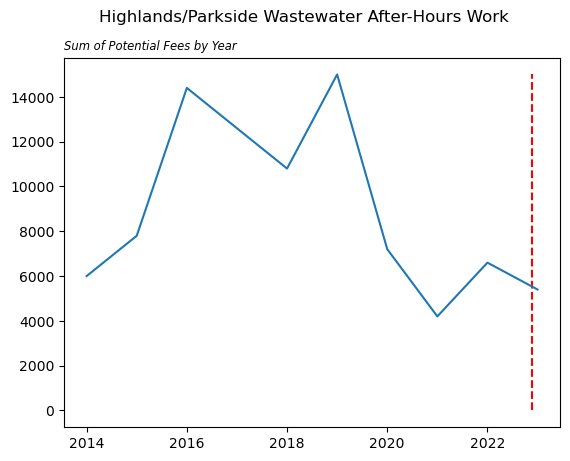

In [600]:
import matplotlib.pyplot as plt
date = df_vis.date
cost = df_vis.fee

fig, ax = plt.subplots()
ax.vlines(x=2022.89, ymin=0, ymax=max(cost), colors='r', linestyles='--', label='12-month')
ax.set_title('Highlands/Parkside Wastewater After-Hours Work', loc='left', style='italic')
ax.plot(date, cost)
plt.suptitle('Highlands/Parkside Wastewater After-Hours Work')
plt.title('Sum of Potential Fees by Year', loc='left', fontsize='small', style='italic')
plt.show()
# df_vis.plot(x='date', y='cost', title='Mayfield Booked Labor Cost by Year')

In [495]:
min(cost)

9496.72671552

In [427]:
df_eligible = df_out.loc[df_out.date >= then, :]
df_eligible['cost'] = df_eligible.apply(calculate_cost, axis = 1) 

C:\Users\Ckluge\AppData\Local\Temp\ipykernel_86456\1475910105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eligible['cost'] = df_eligible.apply(calculate_cost, axis = 1)


In [447]:
df_eligible.date.min()

Timestamp('2022-11-22 18:00:00')

In [442]:
df_eligible.cost.sum()

1733.0

In [441]:
df_eligible.to_csv('../data/mayfield_eligible_service_calls.csv')

In [438]:
revenue_lost = abs(df_vis.cost.sum() - df_eligible.cost.sum())

In [439]:
print(f'Revenue lost = {revenue_lost}')

Revenue lost = 43464.76507327999


In [512]:
df_eligible.booked_labor.sum() / 2 * 100

2250.0

In [510]:
df_vis.booked_labor.sum()

544.250001

In [508]:
print(f'Trucks approx.: {df_vis.booked_labor.sum() / 2 * 100}')

Trucks approx.: 54425.0001


In [604]:
df_out.loc[df_out.after_hours == True, :].location.value_counts()

location
HML    81
MFL    60
Name: count, dtype: int64

In [606]:
df_out.loc[df_out.after_hours == True, :]. info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 111679 to 181703
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   EVT_CODE      150 non-null    object        
 1   date          150 non-null    datetime64[ns]
 2   location      141 non-null    object        
 3   obj_code      150 non-null    object        
 4   gis_id        150 non-null    object        
 5   obj_class     150 non-null    object        
 6   labor_type    150 non-null    object        
 7   booked_labor  150 non-null    float64       
 8   after_hours   150 non-null    bool          
 9   eligible      150 non-null    bool          
 10  fee           150 non-null    int64         
 11  cost          150 non-null    float64       
dtypes: bool(2), datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 13.2+ KB


In [633]:
hml_vis = df_out[(df_out.after_hours == True) & (df_out.location == 'HML')]
mfl_vis = df_out[(df_out.after_hours == True) & (df_out.location == 'MFL')]

In [647]:
hml_vis.sort_values('date')

,EVT_CODE,date,location,obj_code,gis_id,obj_class,labor_type,booked_labor,after_hours,eligible,fee,cost
48,162802,2014-10-12 02:25:11.890,HML,S-CS-HML,nan,STATION,N,4.0,True,False,600,146.56
85,164167,2014-10-13 13:58:00.000,HML,S-CS-HML,nan,STATION,N,0.5,True,False,600,18.32
281,164880,2014-10-23 01:42:00.000,HML,11421,nan,PUMP,O,1.0,True,False,600,57.69
381,165056,2014-10-27 14:47:00.000,HML,S-CS-HML,nan,STATION,N,2.0,True,False,600,73.28
748,165915,2014-11-12 17:31:00.000,HML,11421,nan,PUMP,O,2.0,True,False,600,115.38
...,...,...,...,...,...,...,...,...,...,...,...,...
169911,2555763,2022-08-08 16:08:00.000,HML,S-CS-HML,nan,STATION,N,2.0,True,False,600,73.28
177564,2616139,2023-01-23 10:48:00.000,HML,S-CS-HML,nan,STATION,N,1.0,True,True,600,36.64
177765,2617573,2023-02-01 04:53:00.000,HML,S-CS-HML,nan,STATION,N,1.0,True,True,600,36.64
179889,2633761,2023-05-20 00:15:00.000,HML,S-CS-HML,nan,STATION,N,1.0,True,True,600,36.64


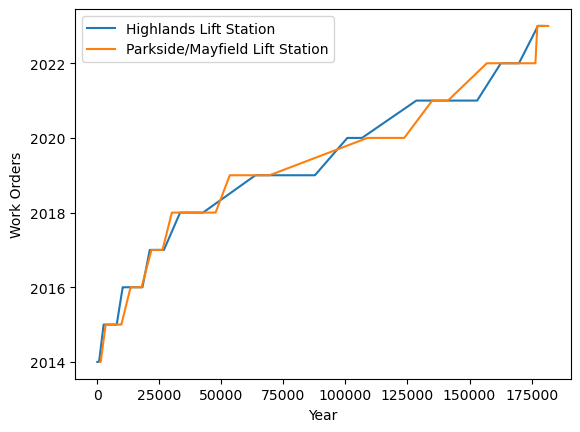

In [638]:
plt.plot(hml_vis.date.dt.year, label = 'Highlands Lift Station')
plt.plot(mfl_vis.date.dt.year, label = 'Parkside/Mayfield Lift Station')

plt.xlabel('Year')
plt.ylabel('Work Orders')
plt.legend()

plt.show()

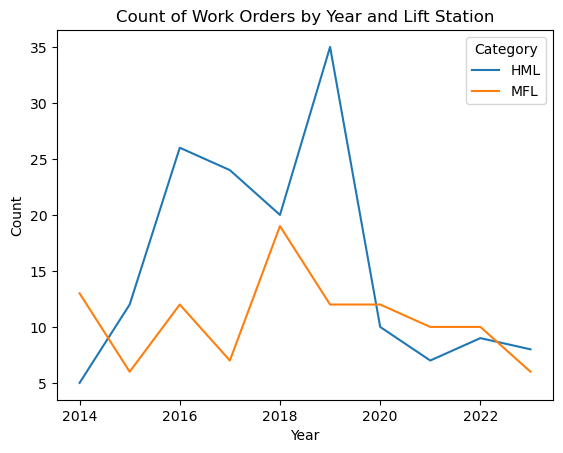

In [644]:
ls_vis = df_out.groupby([df_out.date.dt.year, 'location']).size().unstack(fill_value=0)

ls_vis.plot()
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Work Orders by Year and Lift Station')
plt.legend(title='Category')

plt.show()